<a href="https://colab.research.google.com/github/akhilkapil/NLP-Transfer_Learning_Models/blob/main/BERT_Pytorch_Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install pytorch-pretrained-bert                     

In [ ]:
!pip install transformers

In [ ]:
!pip install bert

In [ ]:
import transformers
from nltk.corpus import stopwords
import spacy

In [ ]:
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
import pandas as pd
import numpy as np
import torch.nn as nn
import warnings 
warnings.filterwarnings('ignore')
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
train = pd.read_csv('//content/drive/My Drive/Data/train.csv')
test= pd.read_csv('//content/drive/My Drive/Data/test.csv')

In [ ]:
train = train.drop('id', axis=1)
train.head()

,label,tweet
0,0,fingerprint Pregnancy Test android apps beaut...
1,0,Finally a transparant silicon case Thanks to ...
2,0,We love this Would you go talk makememories un...
3,0,Im wired I know Im George I was made that way ...
4,1,What amazing service Apple wont even talk to m...


In [ ]:
#Converted them to lower case
train['tweet'] = train['tweet'].str.lower()
test['tweet'] = test['tweet'].str.lower()

In [ ]:
#imort spacy language model
nlp = spacy.load('en', disable=['parser','ner'])

def lemmatization(texts):
  output = []
  for i in texts:
    s = [token.lemma_ for token in nlp(i)]
    output.append(" ".join(s))
  return output

In [ ]:
train['tweet'] = lemmatization(train['tweet'])
test['tweet'] = lemmatization(test['tweet'])

In [ ]:
train

,label,tweet
0,0,fingerprint pregnancy test android app beaut...
1,0,finally a transparant silicon case thank to ...
2,0,-PRON- love this would -PRON- go talk makememo...
3,0,-PRON- be wire i know -PRON- be george i be ma...
4,1,what amazing service apple will not even talk ...
...,...,...
7915,0,live out loud lol liveoutloud selfie smile son...
7916,0,-PRON- would like to wish -PRON- an amazing da...
7917,0,help -PRON- lovely year old neighbor with -P...
7918,0,finally get -PRON- smart pocket wifi stay conn...


In [ ]:
tweets = train.tweet.values
label = train.label.values

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# max_len = 0
# for tweet in tweets:
#   input_ids = tokenizer.encode(tweet,
#                                add_special_tokens=True
#                                )
#   max_len = max(max_len, len(input_ids))

# print('max length:', max_len)


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
input_ids = []
attention_masks = []

for tweet in tweets:
  encode_dict = tokenizer.encode_plus(tweet,
                                      add_special_tokens=True,
                                      max_length=128,
                                      pad_to_max_length=True,
                                      return_attention_mask=True,
                                      return_tensors='pt')
  
  input_ids.append(encode_dict['input_ids'])
  attention_masks.append(encode_dict['attention_mask'])

#convert the list into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(label)

print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  fingerprint pregnancy test   android app beautiful cute health iger iphoneonly iphonesia iphone
Token IDs: tensor([  101,  4344, 16550, 10032,  3231, 11924, 10439,  3376, 10140,  2740,
         1045,  4590, 18059,  2239,  2135, 18059,  8464, 18059,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   

In [ ]:
#Divide data into train and validate
dataset = TensorDataset(input_ids, attention_masks,  labels)

train_df = int(0.75 * len(train))
val_df = len(train) - train_df

#random_split it
train_df, val_df = random_split(dataset,[train_df, val_df])
print(len(val_df))

1980


In [ ]:
#Dataloader 
batch_size = 32
train_dataloader = DataLoader(train_df,
                              sampler=RandomSampler(train_df),
                              batch_size=batch_size) 


val_dataloader = DataLoader(val_df,
                            sampler=SequentialSampler(val_df),
                            batch_size=batch_size)


In [ ]:
#Train Our Classification model

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                         num_labels=2,
                                                         output_attentions=False,
                                                         output_hidden_states=False)
model.cuda()

In [ ]:
# params = list(model.named_parameters())

# print('The BERT model has {:} different named parameters.\n'.format(len(params)))

# print('==== Embedding Layer ====\n')

# for p in params[0:5]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== First Transformer ====\n')

# for p in params[5:21]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== Output Layer ====\n')

# for p in params[-4:]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
#Optimizer

optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-10)


In [ ]:
epochs = 4
steps_per_epoch = int(len(train_df)/batch_size * epochs)

#create a  learning_rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=steps_per_epoch)


In [ ]:
#define a acccuracy function
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
#Helper function for formatting elapsed times as hh:mm:ss
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

##**Training **

Unpack our data inputs and labels

Load data onto the GPU for acceleration

Clear out the gradients calculated in the previous pass.

In pytorch the gradients accumulate by default (useful for things like RNNs) 
unless you explicitly clear them out.

Forward pass (feed input data through the network)

Backward pass (backpropagation)

Tell the network to update parameters with optimizer.step()

Track variables for monitoring progress

In [ ]:
import random
import numpy as np


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
  
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_attention_masks = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_attention_masks, 
                             labels=b_labels)

       
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_attention_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_attention_masks,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(preds=logits, labels=label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    186.    Elapsed: 0:00:26.
  Batch    80  of    186.    Elapsed: 0:00:52.
  Batch   120  of    186.    Elapsed: 0:01:20.
  Batch   160  of    186.    Elapsed: 0:01:49.

  Average training loss: 0.28
  Training epcoh took: 0:02:07

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.22
  Validation took: 0:00:15

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    186.    Elapsed: 0:00:28.
  Batch    80  of    186.    Elapsed: 0:00:57.
  Batch   120  of    186.    Elapsed: 0:01:25.
  Batch   160  of    186.    Elapsed: 0:01:53.

  Average training loss: 0.18
  Training epcoh took: 0:02:11

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.25
  Validation took: 0:00:16

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    186.    Elapsed: 0:00:28.
  Batch    80  of    186.    Elapsed: 0:00:57.
  Batch   120  of    186.    Elapsed: 0:01:25.
  Batch   160  of    186.    Elapsed: 0:01:53.



In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.28,0.22,0.9,0:02:07,0:00:15
2,0.18,0.25,0.9,0:02:11,0:00:16
3,0.14,0.27,0.9,0:02:12,0:00:16
4,0.11,0.32,0.9,0:02:11,0:00:16


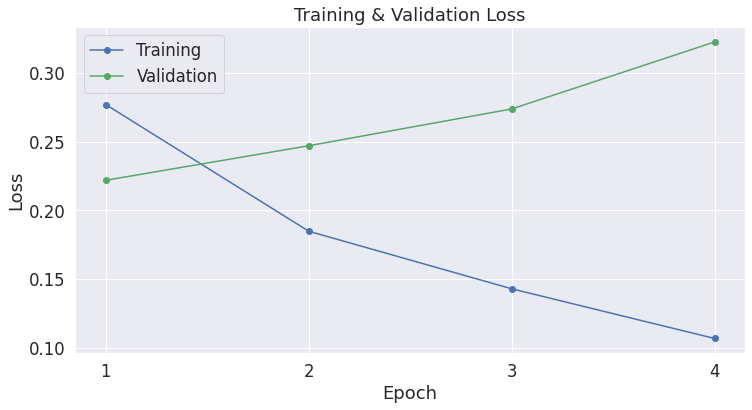

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
tweets_test = test['tweet'].values
tweets_test

array(['i hate the new iphone upgrade will not let -PRON- download app ugh apple suck',
       'currently shit -PRON- fucking pant apple imac cashmoney raddest swagswagswag',
       '-PRON- would like to put some cdrom on -PRON- ipad be that possible — yes but would not that block the screen',
       ...,
       'there go a crack right across the screen if -PRON- could actually provide a more durable screen that would be great apple iphone',
       '  as i say adobe big time -PRON- may well as include apple to',
       'finally i get -PRON-   thanx -PRON- father   samsung galaxy s gift father phone new'],
      dtype=object)

In [ ]:
input_ids = []
attention_masks = []

# For every sentence...
for tweet in tweets:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                                        tweet,                      # Sentence to encode.
                                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                        max_length = 128,           # Pad & truncate all sentences.
                                        pad_to_max_length = True,
                                        return_attention_mask = True,   # Construct attn. masks.
                                        return_tensors = 'pt',     # Return pytorch tensors.
                                  )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
model.eval()

#Tracking variables
predictions, true_labels = [],[]

for batch in prediction_dataloader:

  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_attention_masks = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_attention_masks)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  # label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  # true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [ ]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
test_df['labels'] = flat_predictions
test_df.to_csv('submission_tweets.csv')